#KNN (K Nearest Neighbors)
- For filling missing values

###Jaccard Coefficient / Jaccard Distance
- categorical data/binary
- $J(A,B) = \dfrac{|A \cap B|}{|A \cup B}$
- good for text

In [9]:
import pandas as pd

houses = pd.DataFrame({
        'rooms': [2, 1],
        'bathrooms': [1, 1],
        'stove': ['gas', 'electric'],
        'heat': ['radiator', 'radiator'],
})

print 'Jacard Distance', 2.0/ 6

houses

Jacard Distance 0.333333333333


,bathrooms,heat,rooms,stove
0,1,radiator,2,gas
1,1,radiator,1,electric


In [10]:
houses = pd.DataFrame({
        'rooms': [2, 1],
        'bathrooms': [1, 1],
        'stove': ['gas', 'electric'],
        'heat': ['electric', 'radiator'],
})

print 'Jacard Distance', 1.0/ 7

houses

Jacard Distance 0.142857142857


,bathrooms,heat,rooms,stove
0,1,electric,2,gas
1,1,radiator,1,electric


###Minkowski distance
- Manhattan (P=1)
- Euclidian (P=2)
- For continuous data

In [11]:
import pandas as pd
from sklearn import cross_validation
df = pd.read_csv("/Users/Ikkei/data-analysis/DAT18NYC//data/credit-data-post-import.csv")

train, test = cross_validation.train_test_split(df)
train = pd.DataFrame(train, columns=df.columns)
test = pd.DataFrame(test, columns=df.columns)

In [12]:
from sklearn.neighbors import KNeighborsRegressor

income_imputer = KNeighborsRegressor(n_neighbors=1)

# split our data into 2 groups; data containing nulls, and data not containing nulls.
# we'll train on the latter and make 'predictions' on the null data to impute monthly_income
train_w_monthly_income = train[train.monthly_income.isnull()==False]
train_w_null_monthly_income = train[train.monthly_income.isnull()==True]

In [13]:
correlations = train_w_monthly_income.corr()

# which columns are most correlated with monthly income?
# This will be one quick way to help us find our KNN features

monthly_income_correlations = pd.Series(correlations.ix[:, 5])
monthly_income_correlations.order(ascending=False)

monthly_income                                 1.000000
number_real_estate_loans_or_lines              0.148170
number_of_open_credit_lines_and_loans          0.108912
number_of_dependents                           0.068314
age                                            0.044064
revolving_utilization_of_unsecured_lines       0.010437
number_of_time30-59_days_past_due_not_worse   -0.012221
number_of_time60-89_days_past_due_not_worse   -0.013310
number_of_times90_days_late                   -0.015033
serious_dlqin2yrs                             -0.023035
debt_ratio                                    -0.037893
Name: monthly_income, dtype: float64

In [14]:
cols = ['number_real_estate_loans_or_lines', 'number_of_open_credit_lines_and_loans']

income_imputer = KNeighborsRegressor(n_neighbors=1, p=2)
income_imputer.fit(train_w_monthly_income[cols], train_w_monthly_income.monthly_income)

# fill in the missing data with the imputed values!
train_w_null_monthly_income['monthly_income'] = income_imputer.predict(train_w_null_monthly_income[cols])

test['monthly_income_imputed'] = income_imputer.predict(test[cols])
test[['monthly_income', 'monthly_income_imputed']].head()

/Users/Ikkei/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


,monthly_income,monthly_income_imputed
0,5834,16800
1,3000,2984
2,4833,6541
3,10000,6352
4,7583,9000


In [15]:
income_imputer = KNeighborsRegressor(n_neighbors=2, p=2)
income_imputer.fit(train_w_monthly_income[cols], train_w_monthly_income.monthly_income)

# fill in the missing data with the imputed values!
train_w_null_monthly_income['monthly_income'] = income_imputer.predict(train_w_null_monthly_income[cols])

test['monthly_income_imputed'] = income_imputer.predict(test[cols])
test[['monthly_income', 'monthly_income_imputed']].head()

/Users/Ikkei/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


,monthly_income,monthly_income_imputed
0,5834,17400.0
1,3000,2442.0
2,4833,8520.5
3,10000,5076.0
4,7583,8305.0


In [16]:
from sklearn import grid_search

imputer = KNeighborsRegressor()
parameters1 = {'p': (1, 2), 'n_neighbors': range(1, 23, 3)}

regr = grid_search.GridSearchCV(imputer, parameters1, scoring='mean_squared_error')
regr.fit(train_w_monthly_income[cols], train_w_monthly_income.monthly_income)

GridSearchCV(cv=None,
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'p': (1, 2), 'n_neighbors': [1, 4, 7, 10, 13, 16, 19, 22]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='mean_squared_error', verbose=0)

- KNN is slow
- Exponential algo

In [17]:
parameters2 = {'metric': ['jaccard'], 'n_neighbors': range(1, 23, 3)}
jac = grid_search.GridSearchCV(imputer, parameters2, scoring='mean_squared_error')
jac.fit(train_w_monthly_income[cols], train_w_monthly_income.monthly_income)

GridSearchCV(cv=None,
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_neighbors': [1, 4, 7, 10, 13, 16, 19, 22], 'metric': ['jaccard']},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='mean_squared_error', verbose=0)

In [18]:
print "----------Minkowski Grid Search-------------"
for score in regr.grid_scores_:
    print score

print regr.best_estimator_ 
print

print "----------Jaccard Grid Search-------------"
for score in jac.grid_scores_:
    print score

print jac.best_estimator_ 

----------Minkowski Grid Search-------------
mean: -162434993.78150, std: 42730844.13012, params: {'n_neighbors': 1, 'p': 1}
mean: -162430180.06193, std: 42732296.16528, params: {'n_neighbors': 1, 'p': 2}
mean: -231367925.50355, std: 74287111.32594, params: {'n_neighbors': 4, 'p': 1}
mean: -231244053.75480, std: 74282370.93435, params: {'n_neighbors': 4, 'p': 2}
mean: -176350165.81234, std: 19895298.74410, params: {'n_neighbors': 7, 'p': 1}
mean: -176364586.79836, std: 19889222.68187, params: {'n_neighbors': 7, 'p': 2}
mean: -162421826.32503, std: 28690880.14921, params: {'n_neighbors': 10, 'p': 1}
mean: -162443881.47452, std: 28693145.50288, params: {'n_neighbors': 10, 'p': 2}
mean: -159192722.08235, std: 36607162.16710, params: {'n_neighbors': 13, 'p': 1}
mean: -159129664.13894, std: 36617198.65494, params: {'n_neighbors': 13, 'p': 2}
mean: -155416086.17902, std: 38634822.26755, params: {'n_neighbors': 16, 'p': 1}
mean: -155368275.40207, std: 38635410.64152, params: {'n_neighbors': 1

In [20]:
from sklearn import grid_search, datasets
from sklearn.neighbors import KNeighborsClassifier

iris = datasets.load_iris()
parameters = {'p': [2], 'n_neighbors':range(1, 100)}
knn = KNeighborsClassifier()
clf = grid_search.GridSearchCV(knn, parameters, scoring='accuracy')
clf.fit(iris.data, iris.target)                            

GridSearchCV(cv=None,
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'p': [2], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=0)

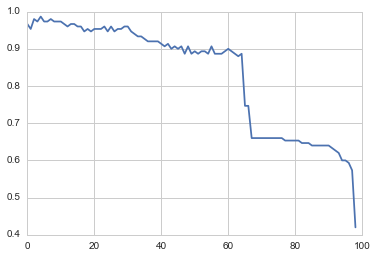

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

scores = [i.mean_validation_score for i in clf.grid_scores_]

sns.set_style('whitegrid')
plt.plot(scores)

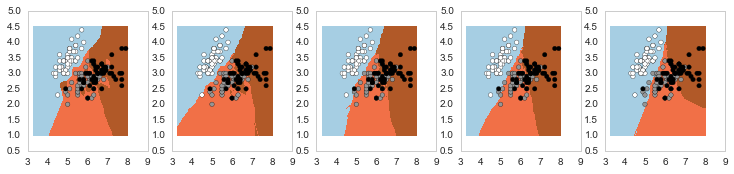

In [23]:
import numpy as np
def plot_estimator(estimator, X, y, ax, pos):
    estimator.fit(X,y)
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + .1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + .1
    xx, yy =np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))
    
    # perform classification on our samples
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
                        
    # Put the result into a color plot
    Z = Z.reshape (xx.shape)
    ax[pos].pcolormesh(xx,yy, Z, cmap=plt.cm.Paired)
                        
    # Lets plot our sample points
    ax[pos].scatter(X[:,0], X[:,1], c=y)
    
fig, axes = plt.subplots(1, 5, figsize=[12.5, 2.5])
for e, k in enumerate([1, 5, 40, 60, 100]):
    plot_estimator(KNeighborsClassifier(n_neighbors=k), iris.data[:,:2], iris.target, axes, e)

# Unsupervised Learning

###Beer Clustering

In [59]:
beer = pd.read_csv("/Users/Ikkei/data-analysis/DAT18NYC/data/beer.txt", sep=r'\s')

In [60]:
beer

,Beer,Calories,Sodium,Alcohol,Cost
0,Budweiser,144,15,4.7,0.43
1,Schlitz,151,19,4.9,0.43
2,Lowenbrau,157,15,0.9,0.48
3,Kronenbourg,170,7,5.2,0.73
4,Heineken,152,11,5.0,0.77
5,Old_Milwaukee,145,23,4.6,0.28
6,Augsberger,175,24,5.5,0.40
7,Srohs_Bohemian_Style,149,27,4.7,0.42
8,Miller_Lite,99,10,4.3,0.43
9,Budweiser_Light,113,8,3.7,0.40


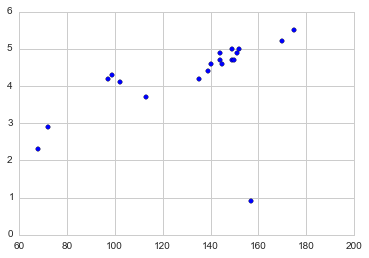

In [61]:
plt.scatter(beer.Calories, beer.Alcohol)

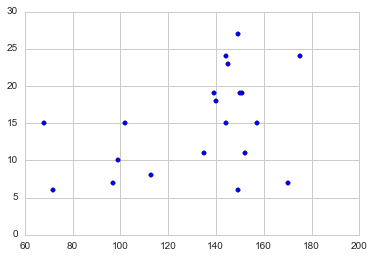

In [62]:
plt.scatter(beer.Calories, beer.Sodium)

#K Means
- Move centroids around to find distances
- Eucredian distance
- Good for cntinuous data

(1, 75)

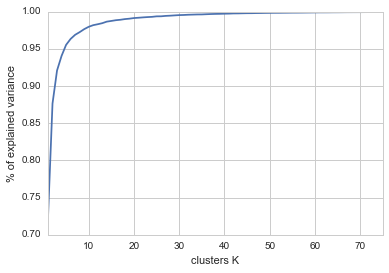

In [54]:
from sklearn import cluster
from __future__ import division

sepal_data = iris.data[:, :2] # just use 2 features
krange = range(1, int(sepal_data.shape[0] / 2))
sum_squares = [cluster.KMeans(n_clusters=k).fit(sepal_data).inertia_ for k in krange]

variance_explained = [1.0 - (s / sum(sum_squares)) for s in sum_squares]
plt.figure()
plt.plot(range(1, 75), variance_explained)
plt.ylabel('% of explained variance')
plt.xlabel('clusters K')
plt.xlim([1, 75])

- The elbow rule
- Num of K and variance explained
- Use 3 or 4 K
- Means 3 or 4 types?

(1, 11)

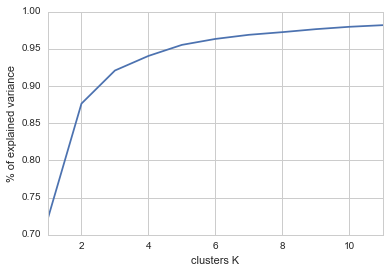

In [55]:
plt.figure()
plt.plot(range(1, 12), variance_explained[:11])
plt.ylabel('% of explained variance')
plt.xlabel('clusters K')
plt.xlim([1, 11])

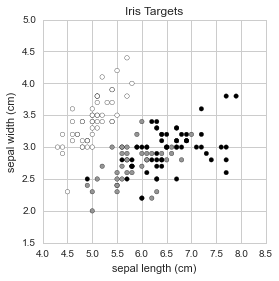

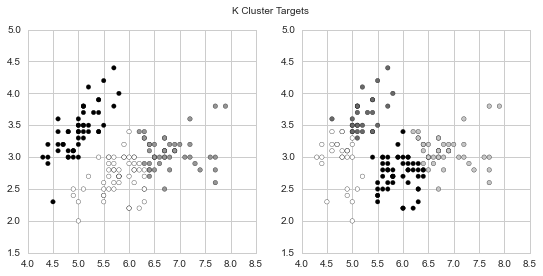

In [57]:
## -- Actual --
plt.figure(figsize=[4, 4])
plt.scatter(sepal_data[:, 0], sepal_data[:, 1], c=iris.target)
plt.title('Iris Targets')
plt.ylabel(iris.feature_names[1])
plt.xlabel(iris.feature_names[0])

## -- 3 Clusters --
clusters_3 = cluster.KMeans(n_clusters=3).fit(sepal_data)
fig, ax = plt.subplots(1, 2, figsize=[9, 4])
fig.suptitle('K Cluster Targets')
ax[0].scatter(sepal_data[:, 0], sepal_data[:, 1], c=clusters_3.predict(sepal_data))

## -- 4 Clusters --
clusters_4 = cluster.KMeans(n_clusters=4).fit(sepal_data)
ax[1].scatter(sepal_data[:, 0], sepal_data[:, 1], c=clusters_4.predict(sepal_data))

- how far
- how cohesive

In [58]:
from sklearn import tree

# fit a classification tree with max_depth=2 on all data
treeclf = tree.DecisionTreeClassifier(max_depth=2, random_state=1)
treeclf.fit(sepal_data, clusters_3.predict(sepal_data))

# create a Graphviz file
with open("iris_clusters.dot", 'wb') as f:
    f = tree.export_graphviz(treeclf, out_file=f, feature_names=iris.feature_names[:3])

In [66]:
beer[['Alcohol', 'Cost']]

,Alcohol,Cost
0,4.7,0.43
1,4.9,0.43
2,0.9,0.48
3,5.2,0.73
4,5.0,0.77
5,4.6,0.28
6,5.5,0.40
7,4.7,0.42
8,4.3,0.43
9,3.7,0.40


In [75]:
beer.Cost = beer.Cost * 100

In [77]:
beer[['Alcohol', 'Cost']]

,Alcohol,Cost
0,4.7,43
1,4.9,43
2,0.9,48
3,5.2,73
4,5.0,77
5,4.6,28
6,5.5,40
7,4.7,42
8,4.3,43
9,3.7,40


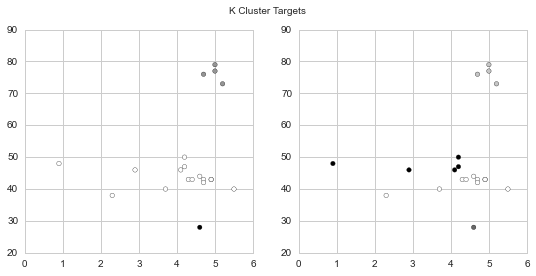

In [78]:
fig, ax = plt.subplots(1, 2, figsize=[9, 4])
fig.suptitle('K Cluster Targets')

clusters_3 = cluster.KMeans(n_clusters=3).fit(beer[['Alcohol', 'Cost']])
ax[0].scatter(beer[['Alcohol']], beer[['Cost']], c=clusters_3.predict(beer[['Alcohol', 'Cost']]))

## -- 4 Clusters --
clusters_4 = cluster.KMeans(n_clusters=4).fit(beer[['Alcohol', 'Cost']])
ax[1].scatter(beer[['Alcohol']], beer[['Cost']], c=clusters_4.predict(beer[['Alcohol', 'Cost']]))

In [79]:
beer

,Beer,Calories,Sodium,Alcohol,Cost
0,Budweiser,144,15,4.7,43
1,Schlitz,151,19,4.9,43
2,Lowenbrau,157,15,0.9,48
3,Kronenbourg,170,7,5.2,73
4,Heineken,152,11,5.0,77
5,Old_Milwaukee,145,23,4.6,28
6,Augsberger,175,24,5.5,40
7,Srohs_Bohemian_Style,149,27,4.7,42
8,Miller_Lite,99,10,4.3,43
9,Budweiser_Light,113,8,3.7,40


/Users/Ikkei/anaconda/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:797: RuntimeWarning: Got data type int64, converted to float to avoid overflows
  X = self._check_test_data(X)


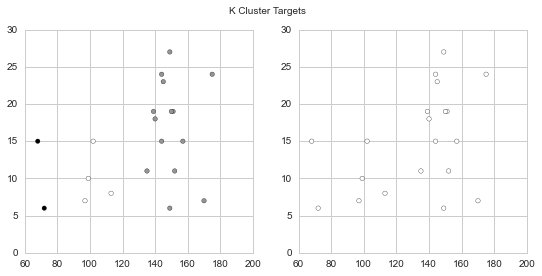

In [81]:
fig, ax = plt.subplots(1, 2, figsize=[9, 4])
fig.suptitle('K Cluster Targets')

clusters_3 = cluster.KMeans(n_clusters=3).fit(beer[['Calories', 'Sodium']])
ax[0].scatter(beer[['Calories']], beer[['Sodium']], c=clusters_3.predict(beer[['Calories', 'Sodium']]))

## -- 4 Clusters --
clusters_4 = cluster.KMeans(n_clusters=4).fit(beer[['Alcohol', 'Cost']])
ax[1].scatter(beer[['Calories']], beer[['Sodium']], c=clusters_4.predict(beer[['Calories', 'Sodium']]))

- Use standard diviation to normalize the data
- Use mean to normalize data

#Google search clustering

In [85]:
import bs4
import requests

url = 'https://www.google.com/search?q=data+science&start=%s'

dfs = []
for i in range(100):
    l = requests.get(url % i)
    soup = bs4.BeautifulSoup(l.text)
    spans = soup.findAll('span', { "class" : "st" })
    tmp_df = pd.DataFrame([span.text.encode('ascii', 'replace') for span in spans])
    dfs.append(tmp_df)

In [100]:
# example 1
goog = pd.concat(dfs)

# example 2
# des = pd.DataFrame()
# starting_df = DataFrame()
# for df in dfs:
#     starting_df.append(df)
#     des.con(df)

In [103]:
goog.reset_index(drop=True, inplace=True)
goog.columns = ['des']
goog.head()

,des
0,"In general terms, data science is the extracti..."
1,Data Science is a specialization offered by Jo...
2,The data science initiative at NYU is a univer...
3,Meet the people who can coax treasure out of m...
4,"According to Gartner, ""Big Data Discovery"" is ..."


In [118]:
goog.to_pickle('goog.pickle')

In [104]:
from sklearn.feature_extraction.text import CountVectorizer

In [119]:
vec = CountVectorizer(ngram_range=(1,1))
X = vec.fit_transform(goog.des)

In [120]:
X_back = X.toarray()
des = pd.DataFrame(X_back, columns=vec.get_feature_names())
des.head()

,000,10,1105,118709,12,140,15,17,1700,18,...,worry,wrangling,writing,written,wsc,xiao,york,you,young,your
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [121]:
cluster.KMeans(n_clusters=3).fit(des)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0)

- TFIDF
- linear karnel (cosign similarity)
- feature selection (words > 50 times)
- kneans to cluster